##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Calculate gradients

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/gradients"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial explores gradient calculation algorithms for the expectation values of quantum circuits.

Calculating the gradient of the expectation value of a certain observable in a quantum circuit is an involved process. Expectation values of observables do not have the luxury of having analytic gradient formulas that are always easy to write down—unlike traditional machine learning transformations such as matrix multiplication or vector addition that have analytic gradient formulas which are easy to write down. As a result, there are different quantum gradient calculation methods that come in handy for different scenarios. This tutorial compares and contrasts two different differentiation schemes.

## Setup

In [2]:
!pip install tensorflow==2.7.0

  Using cached tensorflow-2.7.0-cp39-cp39-manylinux2010_x86_64.whl (489.7 MB)
  Using cached flatbuffers-2.0.7-py2.py3-none-any.whl (26 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0rc0
    Uninstalling tensorflow-estimator-2.14.0rc0:
      Successfully uninstalled tensorflow-estimator-2.14.0rc0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0rc0
    Uninstalling keras-2.14.0rc0:
      Successfully uninstalled keras-2.14.0rc0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: gast
    Found existing ins

Install TensorFlow Quantum:

In [3]:
!pip install tensorflow-quantum==0.7.2

  Using cached tensorflow_quantum-0.7.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (10.5 MB)
  Using cached cirq_core-0.13.1-py3-none-any.whl (1.6 MB)
  Obtaining dependency information for cirq-google>=0.13.1 from https://files.pythonhosted.org/packages/7f/44/fd0b117b9663751b8bb11609159b651a691b3bfb1dbffd5e085e4bb3efee/cirq_google-1.2.0-py3-none-any.whl.metadata
  Using cached cirq_google-1.2.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached sympy-1.8-py3-none-any.whl (6.1 MB)
  Using cached googleapis_common_protos-1.52.0-py2.py3-none-any.whl (100 kB)
  Using cached google_api_core-1.21.0-py2.py3-none-any.whl (90 kB)
  Using cached google_auth-1.18.0-py2.py3-none-any.whl (90 kB)
  Using cached protobuf-3.17.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Obtaining dependency information for duet~=0.2.0 from https://files.pythonhosted.org/packages/be/95/03c8215f675349ff719cb44cd837c2468fdc0c05f55f523f3cad86bbdcc6/duet-0.2.9-py3-none-any.whl.metadata
 

  Using cached google_api_core-1.22.0-py2.py3-none-any.whl (91 kB)
Using cached duet-0.2.9-py3-none-any.whl (29 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.3.1
    Uninstalling cachetools-5.3.1:
      Successfully uninstalled cachetools-5.3.1
  Attempting uninstall: googleapis-common-protos
    Found existing installation: googleapis-common-protos 1.60.0
    Uninstalling googleapis-common-protos-1.60.0:
      Successfully uninstalled googleapis-common-protos-1.60.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.22.0
    Uninstalling google-auth-2.22.0:
      Successfully uninstalled google-auth-2.22

In [4]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [5]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-08-28 11:17:39.704046: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 1. Preliminary

Let's make the notion of gradient calculation for quantum circuits a little more concrete. Suppose you have a parameterized circuit like this one:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


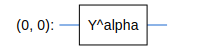

In [6]:
qubit = cirq.GridQubit(0, 0)
my_circuit = cirq.Circuit(cirq.Y(qubit)**sympy.Symbol('alpha'))
SVGCircuit(my_circuit)

Along with an observable:

In [7]:
pauli_x = cirq.X(qubit)
pauli_x

cirq.X(cirq.GridQubit(0, 0))

Looking at this operator you know that $⟨Y(\alpha)| X | Y(\alpha)⟩ = \sin(\pi \alpha)$

In [8]:
def my_expectation(op, alpha):
    """Compute ⟨Y(alpha)| `op` | Y(alpha)⟩"""
    params = {'alpha': alpha}
    sim = cirq.Simulator()
    final_state_vector = sim.simulate(my_circuit, params).final_state_vector
    return op.expectation_from_state_vector(final_state_vector, {qubit: 0}).real


my_alpha = 0.3
print("Expectation=", my_expectation(pauli_x, my_alpha))
print("Sin Formula=", np.sin(np.pi * my_alpha))

Expectation= 0.80901700258255
Sin Formula= 0.8090169943749475


 and if you define $f_{1}(\alpha) = ⟨Y(\alpha)| X | Y(\alpha)⟩$ then $f_{1}^{'}(\alpha) = \pi \cos(\pi \alpha)$. Let's check this:

In [9]:
def my_grad(obs, alpha, eps=0.01):
    grad = 0
    f_x = my_expectation(obs, alpha)
    f_x_prime = my_expectation(obs, alpha + eps)
    return ((f_x_prime - f_x) / eps).real


print('Finite difference:', my_grad(pauli_x, my_alpha))
print('Cosine formula:   ', np.pi * np.cos(np.pi * my_alpha))

Finite difference: 1.8063604831695557
Cosine formula:    1.8465818304904567


## 2. The need for a differentiator

With larger circuits, you won't always be so lucky to have a formula that precisely calculates the gradients of a given quantum circuit. In the event that a simple formula isn't enough to calculate the gradient, the `tfq.differentiators.Differentiator` class allows you to define algorithms for computing the gradients of your circuits. For instance you can recreate the above example in TensorFlow Quantum (TFQ) with:

In [10]:
expectation_calculation = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

expectation_calculation(my_circuit,
                        operators=pauli_x,
                        symbol_names=['alpha'],
                        symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.80901706]], dtype=float32)>

However, if you switch to estimating expectation based on sampling (what would happen on a true device) the values can change a little bit. This means you now have an imperfect estimate:

In [11]:
sampled_expectation_calculation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sampled_expectation_calculation(my_circuit,
                                operators=pauli_x,
                                repetitions=500,
                                symbol_names=['alpha'],
                                symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.808]], dtype=float32)>

This can quickly compound into a serious accuracy problem when it comes to gradients:

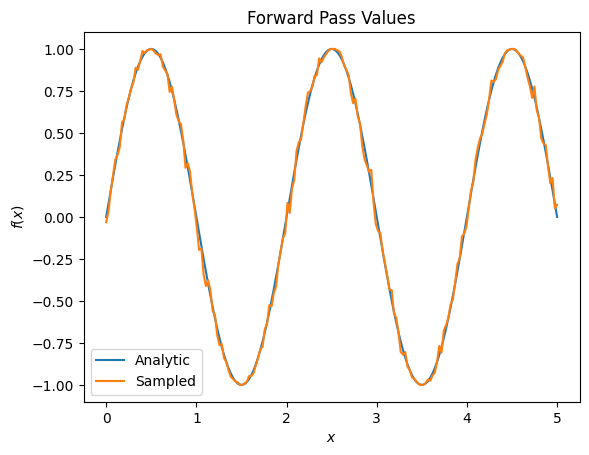

In [12]:
# Make input_points = [batch_size, 1] array.
input_points = np.linspace(0, 5, 200)[:, np.newaxis].astype(np.float32)
exact_outputs = expectation_calculation(my_circuit,
                                        operators=pauli_x,
                                        symbol_names=['alpha'],
                                        symbol_values=input_points)
imperfect_outputs = sampled_expectation_calculation(my_circuit,
                                                    operators=pauli_x,
                                                    repetitions=500,
                                                    symbol_names=['alpha'],
                                                    symbol_values=input_points)
plt.title('Forward Pass Values')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(input_points, exact_outputs, label='Analytic')
plt.plot(input_points, imperfect_outputs, label='Sampled')
plt.legend()

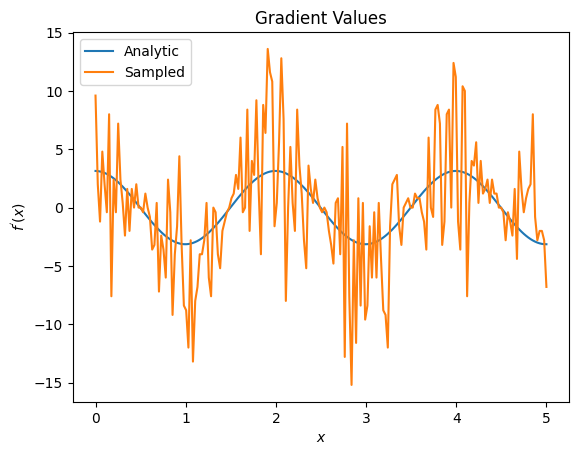

In [13]:
# Gradients are a much different story.
values_tensor = tf.convert_to_tensor(input_points)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=pauli_x,
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)
analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = sampled_expectation_calculation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)
sampled_finite_diff_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_finite_diff_gradients, label='Sampled')
plt.legend()

Here you can see that although the finite difference formula is fast to compute the gradients themselves in the analytical case, when it came to the sampling based methods it was far too noisy. More careful techniques must be used to ensure a good gradient can be calculated. Next you will look at a much slower technique that wouldn't be as well suited for analytical expectation gradient calculations, but does perform much better in the real-world sample based case:

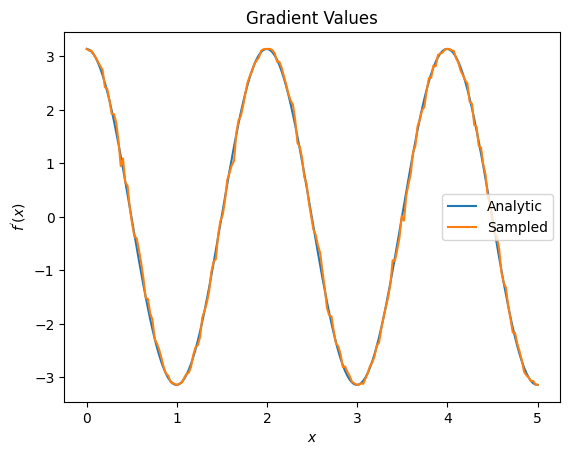

In [14]:
# A smarter differentiation scheme.
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = gradient_safe_sampled_expectation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)

sampled_param_shift_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_param_shift_gradients, label='Sampled')
plt.legend()

From the above you can see that certain differentiators are best used for particular research scenarios. In general, the slower sample-based methods that are robust to device noise, etc., are great differentiators when testing or implementing algorithms in a more "real world" setting. Faster methods like finite difference are great for analytical calculations and you want higher throughput, but aren't yet concerned with the device viability of your algorithm.

## 3. Multiple observables

Let's introduce a second observable and see how TensorFlow Quantum supports multiple observables for a single circuit.

In [15]:
pauli_z = cirq.Z(qubit)
pauli_z

cirq.Z(cirq.GridQubit(0, 0))

If this observable is used with the same circuit as before, then you have $f_{2}(\alpha) = ⟨Y(\alpha)| Z | Y(\alpha)⟩ = \cos(\pi \alpha)$ and $f_{2}^{'}(\alpha) = -\pi \sin(\pi \alpha)$. Perform a quick check:

In [16]:
test_value = 0.

print('Finite difference:', my_grad(pauli_z, test_value))
print('Sin formula:      ', -np.pi * np.sin(np.pi * test_value))

Finite difference: -0.04934072494506836
Sin formula:       -0.0


It's a match (close enough).

Now if you define $g(\alpha) = f_{1}(\alpha) + f_{2}(\alpha)$ then $g'(\alpha) = f_{1}^{'}(\alpha) + f^{'}_{2}(\alpha)$. Defining more than one observable in TensorFlow Quantum to use along with a circuit is equivalent to adding on more terms to $g$.

This means that the gradient of a particular symbol in a circuit is equal to the sum of the gradients with regards to each observable for that symbol applied to that circuit. This is compatible with TensorFlow gradient taking and backpropagation (where you give the sum of the gradients over all observables as the gradient for a particular symbol).

In [17]:
sum_of_outputs = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sum_of_outputs(my_circuit,
               operators=[pauli_x, pauli_z],
               symbol_names=['alpha'],
               symbol_values=[[test_value]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.9106855e-15, 1.0000000e+00]], dtype=float32)>

Here you see the first entry is the expectation w.r.t Pauli X, and the second is the expectation w.r.t Pauli Z. Now when you take the gradient:

In [18]:
test_value_tensor = tf.convert_to_tensor([[test_value]])

with tf.GradientTape() as g:
    g.watch(test_value_tensor)
    outputs = sum_of_outputs(my_circuit,
                             operators=[pauli_x, pauli_z],
                             symbol_names=['alpha'],
                             symbol_values=test_value_tensor)

sum_of_gradients = g.gradient(outputs, test_value_tensor)

print(my_grad(pauli_x, test_value) + my_grad(pauli_z, test_value))
print(sum_of_gradients.numpy())

3.0917350202798843
[[3.0917213]]


Here you have verified that the sum of the gradients for each observable is indeed the gradient of $\alpha$. This behavior is supported by all TensorFlow Quantum differentiators and plays a crucial role in the compatibility with the rest of TensorFlow.

## 4. Advanced usage
All differentiators that exist inside of TensorFlow Quantum subclass `tfq.differentiators.Differentiator`. To implement a differentiator, a user must implement one of two interfaces.  The standard is to implement `get_gradient_circuits`, which tells the base class which circuits to measure to obtain an estimate of the gradient.  Alternatively, you can overload `differentiate_analytic` and `differentiate_sampled`; the class `tfq.differentiators.Adjoint` takes this route.

The following uses TensorFlow Quantum to implement the gradient of a circuit.  You will use a small example of parameter shifting.

Recall the circuit you defined above, $|\alpha⟩ = Y^{\alpha}|0⟩$.  As before, you can define a function as the expectation value of this circuit against the $X$ observable, $f(\alpha) = ⟨\alpha|X|\alpha⟩$.  Using [parameter shift rules](https://pennylane.ai/qml/glossary/parameter_shift.html), for this circuit, you can find that the derivative is
$$\frac{\partial}{\partial \alpha} f(\alpha) = \frac{\pi}{2} f\left(\alpha + \frac{1}{2}\right) -  \frac{ \pi}{2} f\left(\alpha - \frac{1}{2}\right)$$
The `get_gradient_circuits` function returns the components of this derivative.

In [19]:
class MyDifferentiator(tfq.differentiators.Differentiator):
    """A Toy differentiator for <Y^alpha | X |Y^alpha>."""

    def __init__(self):
        pass

    def get_gradient_circuits(self, programs, symbol_names, symbol_values):
        """Return circuits to compute gradients for given forward pass circuits.
        
        Every gradient on a quantum computer can be computed via measurements
        of transformed quantum circuits.  Here, you implement a custom gradient
        for a specific circuit.  For a real differentiator, you will need to
        implement this function in a more general way.  See the differentiator
        implementations in the TFQ library for examples.
        """

        # The two terms in the derivative are the same circuit...
        batch_programs = tf.stack([programs, programs], axis=1)

        # ... with shifted parameter values.
        shift = tf.constant(1/2)
        forward = symbol_values + shift
        backward = symbol_values - shift
        batch_symbol_values = tf.stack([forward, backward], axis=1)
  
        # Weights are the coefficients of the terms in the derivative.
        num_program_copies = tf.shape(batch_programs)[0]
        batch_weights = tf.tile(tf.constant([[[np.pi/2, -np.pi/2]]]),
                                [num_program_copies, 1, 1])

        # The index map simply says which weights go with which circuits.
        batch_mapper = tf.tile(
            tf.constant([[[0, 1]]]), [num_program_copies, 1, 1])

        return (batch_programs, symbol_names, batch_symbol_values,
                batch_weights, batch_mapper)

The `Differentiator` base class uses the components returned from `get_gradient_circuits` to calculate the derivative, as in the parameter shift formula you saw above.  This new differentiator can now be used with existing `tfq.layer` objects:

Text(0.5, 0, 'x')

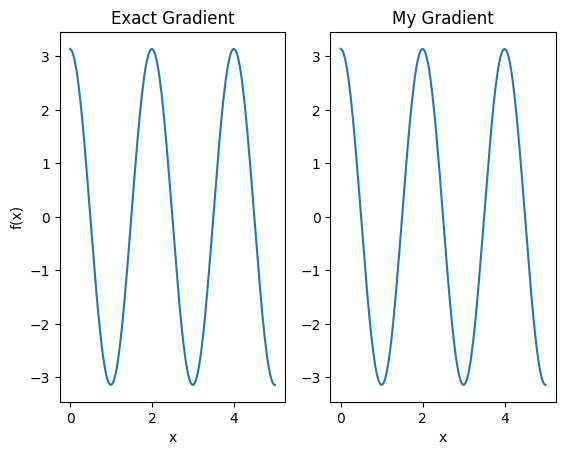

In [20]:
custom_dif = MyDifferentiator()
custom_grad_expectation = tfq.layers.Expectation(differentiator=custom_dif)

# Now let's get the gradients with finite diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=[pauli_x],
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)

analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

# Now let's get the gradients with custom diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    my_outputs = custom_grad_expectation(my_circuit,
                                         operators=[pauli_x],
                                         symbol_names=['alpha'],
                                         symbol_values=values_tensor)

my_gradients = g.gradient(my_outputs, values_tensor)

plt.subplot(1, 2, 1)
plt.title('Exact Gradient')
plt.plot(input_points, analytic_finite_diff_gradients.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.subplot(1, 2, 2)
plt.title('My Gradient')
plt.plot(input_points, my_gradients.numpy())
plt.xlabel('x')

This new differentiator can now be used to generate differentiable ops.

Key Point: A differentiator that has been previously attached to an op must be refreshed before attaching to a new op, because a differentiator may only be attached to one op at a time.

In [21]:
# Create a noisy sample based expectation op.
expectation_sampled = tfq.get_sampled_expectation_op(
    cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.01)))

# Make it differentiable with your differentiator:
# Remember to refresh the differentiator before attaching the new op
custom_dif.refresh()
differentiable_op = custom_dif.generate_differentiable_op(
    sampled_op=expectation_sampled)

# Prep op inputs.
circuit_tensor = tfq.convert_to_tensor([my_circuit])
op_tensor = tfq.convert_to_tensor([[pauli_x]])
single_value = tf.convert_to_tensor([[my_alpha]])
num_samples_tensor = tf.convert_to_tensor([[5000]])

with tf.GradientTape() as g:
    g.watch(single_value)
    forward_output = differentiable_op(circuit_tensor, ['alpha'], single_value,
                                       op_tensor, num_samples_tensor)

my_gradients = g.gradient(forward_output, single_value)

print('---TFQ---')
print('Foward:  ', forward_output.numpy())
print('Gradient:', my_gradients.numpy())
print('---Original---')
print('Forward: ', my_expectation(pauli_x, my_alpha))
print('Gradient:', my_grad(pauli_x, my_alpha))

---TFQ---
Foward:   [[0.7944]]
Gradient: [[1.7888229]]
---Original---
Forward:  0.80901700258255
Gradient: 1.8063604831695557


Success: Now you can use all the differentiators that TensorFlow Quantum has to offer—and define your own.